In [1]:
import keras
import numpy as np

In [4]:
from keras import layers
from keras.utils import image_dataset_from_directory
import os, shutil, pathlib

original_dir = pathlib.Path("cats-dogs-images")
new_base_dir = pathlib.Path("cats_vs_dogs_subset")

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [2]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet", #  weights specifies the weight checkpoint from which to initialize the model.
    include_top=False,  # refers to including (or not) the densely connected classifier on top of the network.
    input_shape=(180,180,3)
)

In [3]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

####  The final feature map has shape (5, 5, 512). That’s the feature map on top of which we’ll stick a densely connected classifier.
<ul>
  <li>Run the convolutional base on the dataset.</li>
  <li>Save the output of the convolutional base as a NumPy array on disk.</li>
  <li>Use this saved data as input for a separate, densely connected classifier (similar to those in chapter 4).</li>
  <li>This approach is fast and inexpensive.</li>
  <li>The convolutional base only needs to be run once per image.</li>
  <li>However, this method does not allow for data augmentation.</li>
</ul>

In [20]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []

    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)
        

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [22]:
train_features.shape # same as conv_base final feature_map

(2000, 5, 5, 512)

In [23]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)


model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="feature-extraction-with-pretrained-model-without-data-augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8778 - loss: 55.4379 - val_accuracy: 0.9630 - val_loss: 5.2555
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9679 - loss: 2.9335 - val_accuracy: 0.9630 - val_loss: 5.6098
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9846 - loss: 1.6177 - val_accuracy: 0.9630 - val_loss: 5.4908
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9857 - loss: 1.6838 - val_accuracy: 0.9600 - val_loss: 7.5738
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9932 - loss: 0.8598 - val_accuracy: 0.9630 - val_loss: 6.7153
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9899 - loss: 0.8016 - val_accuracy: 0.9770 - val_loss: 4.0770
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9968 - loss: 0.9933 - val_accuracy: 0.9670 - val_loss: 5.4168
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9973 - loss: 0.0680 - val_accuracy: 0.9810 - 

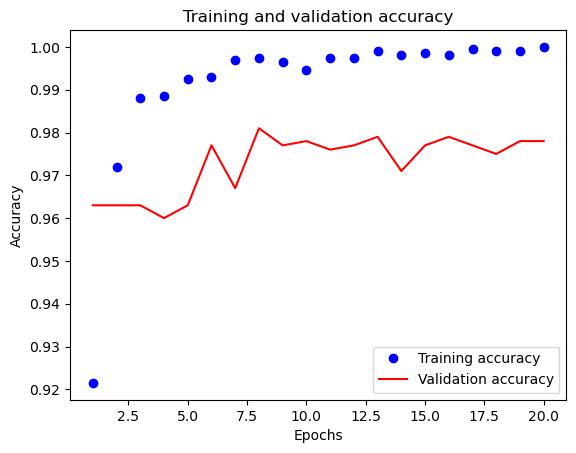

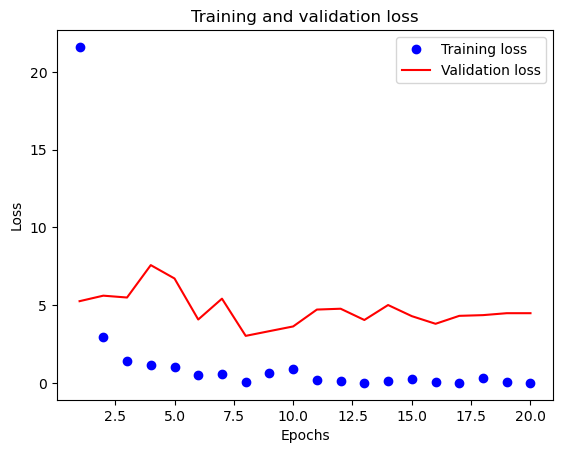

In [28]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "r", label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### You've hit a validation accuracy of around 97% using a pretrained model, which is a significant improvement over training a small model from scratch. However, it's worth noting that ImageNet, the dataset the model was pretrained on, includes many images of dogs and cats, giving it a head start on this specific classification task. The downside is that despite using dropout, you're seeing overfitting very early in the training process. This suggests that data augmentation, which you haven't implemented, is crucial for preventing overfitting when working with small image datasets.